In [1]:
seedNum = 888
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import random
import statsmodels.api as sm
tf.random.set_seed(seedNum)
np.random.seed(seedNum)
import matplotlib.pyplot as plt
from tensorflow import keras
from datetime import datetime
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
import sys, os
print(os.getcwd())
os.chdir('/media/lqs/李秋水的移动硬盘1/DeepCI')
import warnings
warnings.simplefilter('ignore')
import itertools
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

### import from our filesimport
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import log_metrics, plot_results, hyperparam_grid,\
                                     hyperparam_mult_grid, eval_performance
from mliv.neuralnet.mnist_dgps import AbstractMNISTxz
from mliv.neuralnet import AGMM,KernelLayerMMDGMM
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import ADeepCI

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ! pip install statsmodels
device = torch.cuda.current_device() if torch.cuda.is_available() else None
print(torch.cuda.is_available())
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=sys.maxsize)

2023-01-08 14:13:44.588038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 14:13:44.780793: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-08 14:13:45.479076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-08 14:13:45.479130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

/media/lqs/李秋水的移动硬盘1/DeepCI/local_notebooks
False


# use the normal "scale" estimator

In [2]:
#n_epochs = 60
# bs = 2

n_epochs = 200 #80
bs = 50

J = 5

rho = 0.2

func_run = "sin"

In [3]:
def get_function(func_str):
    if func_str == "abs":
        return (lambda x: ((np.abs(np.abs(x)-2)-1.5)/1).flatten(), 
                lambda x: ((torch.abs(torch.abs(x)-2)-1.5)/1).flatten())
    elif func_str == "log":
        return (lambda x: 2*np.log(np.abs(x)).flatten(), 
                lambda x: 2*torch.log(torch.abs(x)).flatten())
    elif func_str == "sin":
        return (lambda x: np.sin(x).flatten(), 
                lambda x: torch.sin(x).flatten())
    else:
        return (lambda x: np.sign(np.abs(np.abs(x)-5)-2).flatten(), 
                lambda x: torch.sign(torch.abs(torch.abs(x)-5)-2).flatten())

In [4]:
def Simdata(NUM_I,seed,func,rho): #a = y_train/test, b = X_train/test
    
    kk = 5
    
    np.random.seed(seed)    
    X_1_a_j = [] 
    X_2_a_j = [] 
    X_1_a_k = [] 
    X_2_a_k = [] 
    X_1_b_j = [] 
    X_2_b_j = [] 
    X_1_b_k = [] 
    X_2_b_k = []
    Z       = []
    for i in tqdm(range(0,NUM_I)):
        #J = np.random.randint(4,10) # number of choice
        
        X_1_a = np.random.uniform(-1,1,J) #customer a
        X_2_a = np.random.uniform(-kk,kk,J)  #customer a # -3 to 3 work well
        X_1_b = np.random.uniform(-1,1,J) #customer b
        X_2_b = np.random.uniform(-kk,kk,J) #customer b
        
        xi  = np.random.normal(0,0.5,J)    # same across all customers
        
        X_2_a = X_2_a + rho*xi  #customer a endogeneity
        
        X_2_b = X_2_b + rho*xi  #customer b endogeneity
        
        u_a   = X_1_a + 2*func(X_2_a) + xi + np.random.normal(0,3,J) # \epsilon_{a} # originally 0.1
        u_b   = X_1_b + 2*func(X_2_b) + xi + np.random.normal(0,3,J) # \epsilon_{b}
        choice_j = np.argmax(u_a) # return the index of product in the sample that customer a chose, we assume customer a as choose j

        choice_k = np.argmax(u_b) # return the index of product in the sample that customer b chose, we assume customer b as choose k
               
        if choice_j == choice_k:
            continue
        else:  

            X_1_a_j.append(X_1_a[choice_j])
            X_2_a_j.append(X_2_a[choice_j])
            X_1_a_k.append(X_1_a[choice_k])
            X_2_a_k.append(X_2_a[choice_k])
            
            X_1_b_j.append(X_1_b[choice_j]) 
            X_2_b_j.append(X_2_b[choice_j]) 
            X_1_b_k.append(X_1_b[choice_k]) 
            X_2_b_k.append(X_2_b[choice_k]) 
            Z.append(np.array([X_1_a[choice_j], X_2_a[choice_j], X_1_a[choice_k], X_2_a[choice_k], 
                                   X_1_b[choice_j], X_2_b[choice_j], X_1_b[choice_k], X_2_b[choice_k]]))
    
    return torch.Tensor(X_1_a_j).reshape((-1,1)).double(), torch.Tensor(X_2_a_j).reshape((-1,1)).double(), \
torch.Tensor(X_1_a_k).reshape((-1,1)).double(), torch.Tensor(X_2_a_k).reshape((-1,1)).double(), torch.Tensor(X_1_b_j).reshape((-1,1)).double(), \
torch.Tensor(X_2_b_j).reshape((-1,1)).double(), torch.Tensor(X_1_b_k).reshape((-1,1)).double(), torch.Tensor(X_2_b_k).reshape((-1,1)).double(), \
torch.tensor(Z, dtype=torch.float64) 

In [5]:
aa,bb = get_function(func_run)

In [6]:
np.random.seed(19104)
X_1_a_j, X_2_a_j, X_1_a_k, X_2_a_k, X_1_b_j, X_2_b_j, X_1_b_k, X_2_b_k, Z = Simdata(10000,2,aa,rho)

100%|██████████| 10000/10000 [00:00<00:00, 40012.78it/s]


In [7]:
tmp = (X_1_a_j[0:100]+2*torch.unsqueeze(aa(X_2_a_j[0:100]),-1))-(X_1_a_k[0:100]+2*torch.unsqueeze(aa(X_2_a_k[0:100]),-1))
torch.sum(tmp<0)

tensor(40)

In [8]:
class CNN_Z_agmm(nn.Module):
    def __init__(self):
        super(CNN_Z_agmm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x  # F.log_softmax(x, dim=1)
        return output.squeeze()


class CNN_Z_kernel(nn.Module):
    def __init__(self, g_features=100):
        super(CNN_Z_kernel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, g_features)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x  # F.log_softmax(x, dim=1)
        return output.squeeze()


class CNN_X(nn.Module):
    def __init__(self):
        super(CNN_X, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 28, 28)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x  # F.log_softmax(x, dim=1)
        return output.squeeze()

In [9]:
def fc_z_kernel(n_z, n_hidden, g_features, dropout_p):
    FC_Z_kernel = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(n_z, n_hidden),
        nn.LeakyReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(n_hidden, g_features),
        nn.ReLU(),
    )
    return FC_Z_kernel


def fc_z_agmm(n_z, n_hidden, dropout_p):
    FC_Z_agmm = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(n_z, n_hidden),
        nn.LeakyReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(n_hidden, 1),
    )
    return FC_Z_agmm


def fc_x(n_t, n_hidden, dropout_p):
    FC_X = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(n_t, n_hidden),
        nn.LeakyReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(n_hidden, 1),
    )
    return FC_X

In [10]:
k = 500
n_hidden = 300
n_instruments = 1
dropout_p = 0.1


class CNN_X(nn.Module):
    def __init__(self):
        super(CNN_X, self).__init__()
        self.conv1 = nn.Linear(1, k)
        self.conv2 = nn.Linear(k, 200)
        self.conv3 = nn.Linear(200, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        #x = F.relu(x)
        output = 1.5*torch.nn.functional.tanh(x)
        return output.squeeze()
    

if func_run == "abs":
    net_learner1 = CNN_X()
else:
    net_learner1 = torch.nn.Sequential(
            torch.nn.Linear(1, k),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(k, 200),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(200, 2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(2, 1),
            torch.nn.Tanh(),
            )
        
        
    


net_learner2 = torch.nn.Sequential(
            torch.nn.Linear(1, k),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(k, 200),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(200, 1),
            )


learner = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(k, n_hidden), nn.LeakyReLU(),
                       nn.Dropout(p=dropout_p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                       nn.Dropout(p=dropout_p), nn.Linear(n_hidden, 1))

adversary_fn = nn.Sequential(nn.Dropout(p=dropout_p), nn.Linear(k, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=dropout_p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                            nn.Dropout(p=dropout_p), nn.Linear(n_hidden, 1))

net_adversary = torch.nn.Sequential(nn.Dropout(p=0.1),
            torch.nn.Linear(8, k),
            torch.nn.LeakyReLU(),
            nn.Dropout(p=0.1),                        
            torch.nn.Linear(k, 200), #200
            torch.nn.LeakyReLU(),
            nn.Dropout(p=0.1),                        
            torch.nn.Linear(200, 1),
            )
 

In [11]:
learner1 = net_learner1.double()

learner2 = net_learner2.double()

adversary = net_adversary.double() #fc_z_agmm(n_instruments, n_hidden, dropout_p)

In [14]:
res1 = ADeepCI(learner1, adversary).fit(X_1_a_j, X_2_a_j, X_1_a_k, X_2_a_k, 
                  X_1_b_j, X_2_b_j, X_1_b_k, X_2_b_k, Z, 
                  learner_l2=1e-3, adversary_l2=1e-4, adversary_norm_reg=1e-3,
                  learner_lr=0.001, adversary_lr=0.001, n_epochs=n_epochs, bs=bs, train_learner_every=1, train_adversary_every=1,
                  ols_weight=0.1, warm_start=False, logger=None, model_dir='.', device=None, verbose=False)

model_final1 = torch.load(os.path.join(res1.model_dir,"epoch{}".format(res1.n_epochs-1)))

res2 = ADeepCI(learner2, adversary).fit(X_1_a_j, X_2_a_j, X_1_a_k, X_2_a_k, 
            X_1_b_j, X_2_b_j, X_1_b_k, X_2_b_k, Z, 
            learner_l2=1e-3, adversary_l2=1e-4, adversary_norm_reg=1e-3,
            learner_lr=0.001, adversary_lr=0.001, n_epochs=n_epochs, bs=bs, train_learner_every=1, train_adversary_every=1,
            ols_weight=0.1, warm_start=False, logger=None, model_dir='.', device=None, verbose=False)
            
model_final2 = torch.load(os.path.join(res2.model_dir,"epoch{}".format(res2.n_epochs - 1)))

Initializing ADeepCI
BaseSupLossADeepCI: Training learner and adversary
epoch 0 D_loss tensor(1038.9198, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-2853287.7593, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 50 D_loss tensor(6850.4877, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-3681898.8012, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 100 D_loss tensor(13474.0553, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-43565374.4751, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 150 D_loss tensor(5036.1747, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-75569439.5787, dtype=torch.float64, grad_fn=<AddBackward0>)
Initializing ADeepCI
BaseSupLossADeepCI: Training learner and adversary
epoch 0 D_loss tensor(902.9743, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-5031375.1185, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 50 D_loss tensor(4670.8981, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss ten

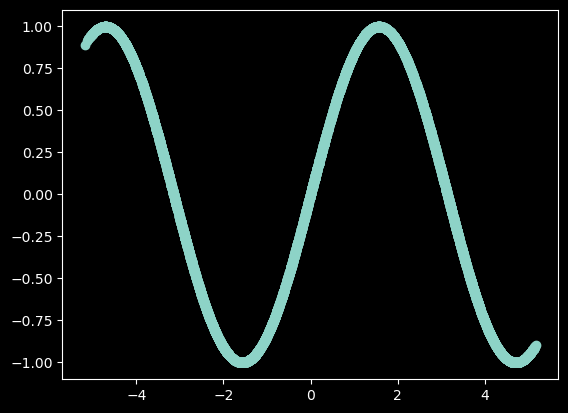

In [15]:
plt.scatter(X_2_a_k.T.squeeze().cpu().data.numpy(), aa(X_2_a_k).cpu().data.numpy())
plt.show()

In [16]:
np.random.seed(19104+1)
X_1_a_j_test, X_2_a_j_test, X_1_a_k_test, X_2_a_k_test, X_1_b_j_test, X_2_b_j_test, X_1_b_k_test, X_2_b_k_test, Z_test = Simdata(10000,2,aa,0.2)

100%|██████████| 10000/10000 [00:00<00:00, 41413.04it/s]


100%|██████████| 10000/10000 [00:00<00:00, 40894.43it/s]


Initializing ADeepCI
BaseSupLossADeepCI: Training learner and adversary
epoch 0 D_loss tensor(111.9801, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-907607.9125, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 50 D_loss tensor(5743.0704, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-34200097.1357, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 100 D_loss tensor(865.8328, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-4032479.0684, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 150 D_loss tensor(194.2857, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-1941093.4052, dtype=torch.float64, grad_fn=<AddBackward0>)


100%|██████████| 10000/10000 [00:00<00:00, 35802.76it/s]


Initializing ADeepCI
BaseSupLossADeepCI: Training learner and adversary
epoch 0 D_loss tensor(89.6182, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-835527.2873, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 50 D_loss tensor(17037.3242, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-53154774.7579, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 100 D_loss tensor(571.1851, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-3510608.1038, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 150 D_loss tensor(28602.4983, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-93518860.9067, dtype=torch.float64, grad_fn=<AddBackward0>)


100%|██████████| 10000/10000 [00:00<00:00, 33097.79it/s]


Initializing ADeepCI
BaseSupLossADeepCI: Training learner and adversary
epoch 0 D_loss tensor(172.9908, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-1655233.5429, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 50 D_loss tensor(15750.1665, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-1.1378e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 100 D_loss tensor(4462.9471, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(-25080001.4888, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch 150 D_loss tensor(178.1920, dtype=torch.float64, grad_fn=<AddBackward0>) G_loss tensor(2.2952e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
MSEs 0.10800354177539041
Biases -0.15927735772856158
Y shape == X shape: False
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Meth

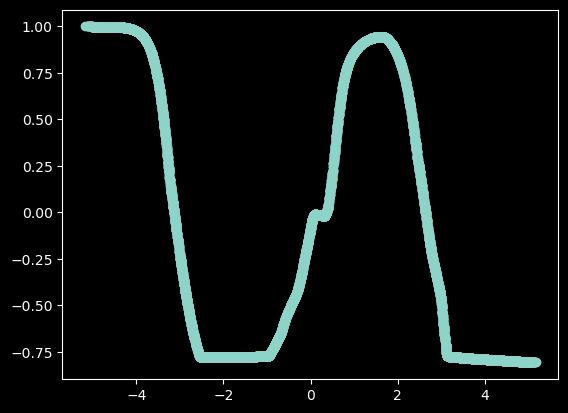

In [17]:
MSEs = []
Biases = []
import numpy as np
for kk in range (0,3):
    np.random.seed(kk)
    X_1_a_j, X_2_a_j, X_1_a_k, X_2_a_k, X_1_b_j, X_2_b_j, X_1_b_k, X_2_b_k, Z = Simdata(10000,2,aa,rho)
    
    res1 = ADeepCI(learner1, adversary).fit(X_1_a_j, X_2_a_j, X_1_a_k, X_2_a_k, 
                  X_1_b_j, X_2_b_j, X_1_b_k, X_2_b_k, Z, 
            learner_l2=1e-3, adversary_l2=1e-4, adversary_norm_reg=1e-3,
            learner_lr=0.0001, adversary_lr=0.0001, n_epochs=n_epochs, bs=bs, train_learner_every=1, train_adversary_every=1,
            ols_weight=0., warm_start=False, logger=None, model_dir='.', device= None, verbose=False)
    
    model_final = torch.load(os.path.join(res1.model_dir,"epoch{}".format(res1.n_epochs - 1)))
    
    y = model_final(X_2_a_k).cpu().data.numpy()
    
    if y.ndim == 2:
        x = aa(X_2_a_k).cpu().data.numpy()[:, np.newaxis]
    else:
        x = aa(X_2_a_k).cpu().data.numpy()


    MSE = np.mean((y - x) ** 2)
    MSEs.append(MSE)
    Bias = np.mean(y-x)
    Biases.append(Bias)
y_pred = 2*(X_1_a_j_test.T.squeeze().cpu().data.numpy() + model_final(X_2_a_j_test).squeeze().cpu().data.numpy() > \
           X_1_a_k_test.T.squeeze().cpu().data.numpy() + model_final(X_2_a_k_test).squeeze().cpu().data.numpy())-1
y = 1*((y_pred+100)>0) # all ones
f1_score(y,y_pred)    
print('MSEs',np.mean(MSEs))
print('Biases',np.mean(Biases))
print("Y shape == X shape: {}".format(y.shape == x.shape))

#Fit and summarize OLS model
x = sm.add_constant(x, prepend=False)
mod = sm.OLS(y,x)
res = mod.fit()
print(res.summary())

import matplotlib.pyplot as plt
import numpy as np

plt.scatter(X_2_a_k.T.squeeze().cpu().data.numpy(), model_final(X_2_a_k).cpu().data.numpy())
plt.savefig(func_run+str(J)+'.png')

Logistic Regression

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [ ]:
X_1 = np.concatenate((X_1_a_j.cpu().data.numpy(),X_2_a_j.cpu().data.numpy()),axis = 1)
X_2 = np.concatenate((X_1_a_k.cpu().data.numpy(),X_2_a_k.cpu().data.numpy()),axis = 1)
y_1 = np.ones(X_1.shape[0])
y_2 = np.zeros(X_1.shape[0])

X = np.concatenate((X_1,X_2), axis = 0)
y = np.concatenate((y_1,y_2), axis = 0)

clf = LogisticRegression(random_state=0).fit(X, y)

X_a_j_test = np.concatenate((X_1_a_j_test.cpu().data.numpy(),X_2_a_j_test.cpu().data.numpy()),axis = 1)

y_pred_clf = 2*clf.predict(X_a_j_test)-1 #1 or -1
y_clf = 1*((y_pred_clf+100)>0) # all ones

f1_score(y_clf,y_pred_clf)

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, roc_auc_score
import sys
import pandas as pd



method = func_run


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_stats(d1_train, d2_train, y_train, d1_test, d2_test, y_test, N, mode):


    print("J:",J, "rho:",rho, "method:",method, "mode:",mode)


    torch.manual_seed(2)    # reproducible

    x1 = torch.tensor(d1_train, dtype=torch.float32)
    x2 = torch.tensor(d2_train, dtype=torch.float32)
    y  = torch.tensor(y_train, dtype=torch.float32)

    # torch can only train on Variable, so convert them to Variable
    x1, x2, y = Variable(x1), Variable(x2), Variable(y)


    if mode == 'PPHI':
        net = torch.nn.Sequential(
            torch.nn.Linear(1, 1),
            torch.nn.Flatten(0, 1)
            )
    elif mode == 'polyPPHI':
        net = torch.nn.Sequential(
            torch.nn.Linear(2, 1),
            torch.nn.Flatten(0, 1)
            )
    else:
        net = torch.nn.Sequential(
            torch.nn.Linear(1, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 200),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(200, 1),
            )


    # print(net)  # net architecture
    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

    if mode == 'PPHI':
        p = torch.tensor([1])
        x10 = torch.unsqueeze(x1[:,0],dim=1)
        x20 = torch.unsqueeze(x2[:,0],dim=1)
        x11 = torch.unsqueeze(x1[:,1:],dim=1).pow(p)
        x21 = torch.unsqueeze(x2[:,1:],dim=1).pow(p)
    elif mode == 'polyPPHI':
        p = torch.tensor([1,2])
        x10 = torch.unsqueeze(x1[:,0],dim=1)
        x20 = torch.unsqueeze(x2[:,0],dim=1)
        x11 = torch.unsqueeze(x1[:,1:],dim=1).pow(p)
        x21 = torch.unsqueeze(x2[:,1:],dim=1).pow(p)
    else:
        p = torch.tensor([1])
        x10 = torch.unsqueeze(x1[:,0],dim=1)
        x20 = torch.unsqueeze(x2[:,0],dim=1)
        x11 = torch.unsqueeze(x1[:,1:],dim=1)
        x21 = torch.unsqueeze(x2[:,1:],dim=1)


    def deepci_loss(first, second, y):
        diff1 = torch.reshape(first - second, (-1,))
        diff = diff1*(y>0) + (-diff1)*(y<0)
        loss = torch.mean(torch.minimum(torch.zeros(diff.size()),diff)**2)
        return loss


    BATCH_SIZE = 64
    EPOCH = 100
    torch_dataset = Data.TensorDataset(x10, x11, x20, x21, y)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=2,)
    iteration = 0

    # start training
    for epoch in range(EPOCH):
        for step, (batch_x10, batch_x11, batch_x20, batch_x21, batch_y) in enumerate(loader): # for each training step

            b_x10 = Variable(batch_x10)
            b_x11 = Variable(batch_x11)
            b_x20 = Variable(batch_x20)
            b_x21 = Variable(batch_x21)
            b_y = Variable(batch_y)

            prediction_1 = b_x10 + net(b_x11)     # input x and predict based on x
            prediction_2 = b_x20 + net(b_x21)

            loss = deepci_loss(prediction_1, prediction_2, b_y)     # must be (1. nn output, 2. target)
            #if iteration%500 == 0:
            #    print(loss)
            iteration +=1    
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients


    x1_test = torch.tensor(d1_test, dtype=torch.float32)
    x2_test = torch.tensor(d2_test, dtype=torch.float32)
    y       = torch.tensor(y_test, dtype=torch.float32)


    if mode == 'PPHI':
        x10_test = torch.unsqueeze(x1_test[:,0],dim=1)
        x20_test = torch.unsqueeze(x2_test[:,0],dim=1)
        x11_test = torch.unsqueeze(x1_test[:,1:],dim=1).pow(p)
        x21_test = torch.unsqueeze(x2_test[:,1:],dim=1).pow(p)
    elif mode == 'polyPPHI':
        x10_test = torch.unsqueeze(x1_test[:,0],dim=1)
        x20_test = torch.unsqueeze(x2_test[:,0],dim=1)
        x11_test = torch.unsqueeze(x1_test[:,1:],dim=1).pow(p)
        x21_test = torch.unsqueeze(x2_test[:,1:],dim=1).pow(p)
    else:
        x10_test = torch.unsqueeze(x1_test[:,0],dim=1)
        x20_test = torch.unsqueeze(x2_test[:,0],dim=1)
        x11_test = torch.unsqueeze(x1_test[:,1:],dim=1)
        x21_test = torch.unsqueeze(x2_test[:,1:],dim=1)


    if mode == 'NN':
        y_pred = 2*(x10_test.flatten() + net(x11_test).data.numpy().flatten() > \
                x20_test.flatten() + net(x21_test).data.numpy().flatten())-1
    else:
        y_pred = 2*((x10_test + net(x11_test)).flatten() > \
                (x20_test + net(x21_test)).flatten())-1

    f1 = f1_score(y.numpy(),y_pred.numpy())
    
    yy = net(x11_test).cpu().data.numpy()
    xx = aa(x1_test[:,1:]).cpu().data.numpy()[:, np.newaxis]

    xx = sm.add_constant(xx, prepend=False)
    # Fit and summarize OLS model
    mod = sm.OLS(yy,xx)
    res = mod.fit()
    print(res.summary())
    print(yy.shape)
    print(xx.shape)
    
    MSE = np.mean((yy - xx) ** 2)
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.abs(yy - xx))
    CE = np.mean(np.abs(yy - xx) / np.abs(xx))
    accuracy_score = np.mean((yy - xx) == 0)
    Bias = np.mean(yy-xx)
        
    return f1, RMSE, MAE, CE, accuracy_score, Bias


def simulateData(N, J, K, func, rho, sim):
    np.random.seed(sim)
    D = np.random.uniform(-1,1,(N,J + 1,K))
    x1 = np.array([])
    x2 = np.array([])
    y  = np.array([])
    for n in range(N):
        err = np.random.normal(0,0.5) # epsilon_m
        D[n,1:,1] = 5*D[n,1:,1] + rho*err
        D[n,1:,0] = D[n,1:,0] 
        choice = np.argmax(D[n,:,0] + 2*func(D[n,:,1:]) + np.random.normal(0,3,(1,J + 1)) + err) # x_0+f(x_1) for each product
        if choice == 0:
            continue
        for j in range(1, J+1):
            if j == choice:
                continue
            else:
                #print(D[n,choice,:])
                if x1.size == 0:
                    x1 = D[n,choice,:]
                    x2 = D[n,j,:]
                    y  = np.array([1])
                else:    
                    x1 = np.c_[x1, D[n,choice,:]]
                    x2 = np.c_[x2, D[n,j,:]]
                    y  = np.c_[y,np.array([1])]
    return x1.T, x2.T, y.T


print(method)


def runConfig(J, rho, method, mode):
    N = 2000
    K = 2
    a, b = get_function(method)
    MSEs = []
    f1 = []
    RMSE = []
    MAE = []
    CE = []
    accuracy_score = []
    for i in range(1,2): 
        d1_train, d2_train, y_train = simulateData(N, J, K, a, rho, i)
        d1_test,  d2_test,  y_test  = simulateData(N, J, K, a, rho, i+1)
        f1, RMSE, MAE, CE, accuracy_score, Bias = compute_stats(d1_train, d2_train, y_train, d1_test, d2_test, y_test, method, mode)
        MSEs.append(MSE)
        Biases.append(Bias)

    return np.mean(MSEs), np.mean(Biases), f1, RMSE, MAE, CE, accuracy_score

In [ ]:
def get_function(func_str):
    if func_str == "abs":
        return (lambda x: (-1+0.4*np.abs(x@np.ones((1,1)))).flatten(), 
                lambda x: (-1+0.4*torch.abs(x@np.ones((1,1)))).flatten())
    elif func_str == "log":
        return (lambda x: 2*np.log(np.abs(x@np.ones((1,1)))).flatten(), 
                lambda x: 2*torch.log(torch.abs(x@np.ones((1,1)))).flatten())
    elif func_str == "sin":
        return (lambda x: np.sin(x@np.ones((1,1))).flatten(), 
                lambda x: torch.sin(x@np.ones((1,1))).flatten())
    else:
        return (lambda x: np.sign(np.abs(np.abs(x@np.ones((1,1)))-5)-2).flatten(), 
                lambda x: torch.sign(torch.abs(torch.abs(x@np.ones((1,1)))-5)-2).flatten())

In [ ]:
mode = 'polyPPHI'

MSE, Bias, f1, RMSE, MAE, CE, accuracy_score = runConfig(5, 0.5, method, mode)
print('MSE: ', MSE, 'Bias: ', Bias, 'f1: ', f1, 'RMSE: ', RMSE, 'MAE: ', MAE, 'CE: ', CE, 'accuracy_score: ', accuracy_score)



In [ ]:
mode = 'PPHI'

MSE, Bias, f1, RMSE, MAE, CE, accuracy_score = runConfig(5, 0.5, method, mode)
print('MSE: ', MSE, 'Bias: ', Bias, 'f1: ', f1, 'RMSE: ', RMSE, 'MAE: ', MAE, 'CE: ', CE, 'accuracy_score: ', accuracy_score)